In [1]:
import dataset
import environment as env
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import renderers
import utils
import torch

# # Use for master:
data = dataset.SvbrdfDataset(data_directory=R"./data/train", 
                             image_size=256, scale_mode='crop', input_image_count=10, used_input_image_count=0, 
                             use_augmentation=False, mix_materials=False,
                             no_svbrdf=False, is_linear=False)

# # Use for redner integration branch:
#data = dataset.SvbrdfDataset(data_directory=R"./data/train", 
#                             image_size=256, input_image_count=10, used_input_image_count=0, 
#                             use_augmentation=False, mix_materials=False)


output_dir     = pathlib.Path("./tmp_out")
output_dir.mkdir(parents=True, exist_ok=True)
output_dir_viz = output_dir.joinpath("viz")
output_dir_viz.mkdir(parents=True, exist_ok=True)

### Writing out the individual SVBRDF maps and a joint map

The normal has to be encoded in the interval [0, 1] for visualization purposes. Diffuse albedo and specular albedo are gamma encoded to be more pleasurable for the human eye.

In [3]:
n, d, r, s = utils.unpack_svbrdf(data[0]['svbrdf'])
n_viz = utils.encode_as_unit_interval(n)
d_viz = utils.gamma_encode(d)
r_viz = r
s_viz = utils.gamma_encode(s)
utils.write_image_tensor(output_dir_viz.joinpath("normal_viz.png"), n_viz)
utils.write_image_tensor(output_dir_viz.joinpath("diffuse_viz.png"), d_viz)
utils.write_image_tensor(output_dir_viz.joinpath("roughness_viz.png"), r_viz)
utils.write_image_tensor(output_dir_viz.joinpath("specular_viz.png"), s_viz)

# Visualization of the SVBRDF
svbrdf_viz = torch.cat([n_viz, d_viz, r_viz, s_viz], dim=-1)
utils.write_image_tensor(output_dir_viz.joinpath("svbrdf_viz.png"), svbrdf_viz)

# Actual representation of the SVBRDF
svbrdf = torch.cat([n_viz, d, r, s], dim=-1)
utils.write_image_tensor(output_dir.joinpath("svbrdf.png"), svbrdf)

NameError: name 'data' is not defined

### Using material mixing to generate a mixed SVBRDF and image generation to obtain input images

In [13]:
num_generated_images = 5

data_svbrdfs = dataset.SvbrdfDataset(data_directory=str(output_dir), 
                                     image_size=256, scale_mode='crop', input_image_count=0, used_input_image_count=num_generated_images,
                                     use_augmentation=False, mix_materials=True,
                                     no_svbrdf=False, is_linear=False)

n, d, r, s = utils.unpack_svbrdf(data_svbrdfs[0]['svbrdf'])
n_viz = utils.encode_as_unit_interval(n)
d_viz = utils.gamma_encode(d)
r_viz = r
s_viz = utils.gamma_encode(s)

# Visualization of the SVBRDF
svbrdf_viz = torch.cat([n_viz, d_viz, r_viz, s_viz], dim=-1)
utils.write_image_tensor(output_dir_viz.joinpath("svbrdf_viz.png"), svbrdf_viz)

images = data_svbrdfs[0]['inputs']
for i in range(num_generated_images):
    utils.write_image_tensor(output_dir_viz.joinpath("input_image_{:d}.png".format(i)), utils.gamma_encode(images[i]))

### Rendering an animated light over the material patch with both renderers

In [17]:
def render_animated(output_path, renderer, svbrdf):
    output_path.mkdir(parents=True, exist_ok=True)
    
    for i, phi in enumerate(np.linspace(0.0, np.pi*2, 120, endpoint=True)):
        cam       = env.Camera([0, 1, 1.4])
        light     = env.Light([1.7 * np.cos(phi), 1.7 * np.sin(phi), 1.7], [30, 30, 30])
        scene     = env.Scene(cam, light)
        rendering = renderer.render(scene, svbrdf).squeeze(0)
        
        mapping   = renderers.OrthoToPerspectiveMapping(cam, (512, 512))
        rendering = mapping.apply(utils.gamma_encode(rendering.clone().cpu().detach().permute(1, 2, 0)).numpy())

        output_file_path = output_path.joinpath("{:d}.png".format(i))
        utils.write_image(output_file_path, rendering)

In [2]:
svbrdf = data[1]['svbrdf']

render_animated(output_dir.joinpath("local"), renderers.LocalRenderer(), svbrdf)
#render_animated(output_dir.joinpath("pathtracing"), renderers.RednerRenderer(), svbrdf)

Using device 'cuda' for redner


### Creating perspective and full patch sample renderings of the material

In [7]:
svbrdf = data[1]['svbrdf']

cam      = env.Camera([0, -1, 1.4])
light    = env.Light([-1.7, 0.0, 1.7], [30, 30, 30])
scene    = env.Scene(cam, light)

rendering_fullpatchsample = utils.gamma_encode(renderers.LocalRenderer().render(scene, svbrdf).squeeze(0).clone().cpu().detach()).permute(1, 2, 0).numpy()
rendering_perspective     = renderers.OrthoToPerspectiveMapping(cam, (512, 512)).apply(rendering_fullpatchsample)

utils.write_image(output_dir_viz.joinpath("fullpatchsample.png"), rendering_fullpatchsample)
utils.write_image(output_dir_viz.joinpath("perspective.png"), rendering_perspective)

### Optimizing normal maps by comparing a re-rendering with a target image (fixed scene)

In [4]:
from IPython.display import clear_output

output_dir_optim_fixed = output_dir.joinpath("optim_fixed")
output_dir_optim_fixed.mkdir(parents=True, exist_ok=True)
output_dir_optim_fixed_svbrdf = output_dir_optim_fixed.joinpath("svbrdf")
output_dir_optim_fixed_svbrdf.mkdir(parents=True, exist_ok=True)

svbrdf_t           = data[1]['svbrdf']
n_t, d_t, r_t, s_t = utils.unpack_svbrdf(svbrdf_t)

# Generated target rendering with known scene configuration
cam      = env.Camera([0, -1, 1.4])             # This configuration breaks the fixed evaluation!
light    = env.Light([1, 1, 1.7], [30, 30, 30]) #
#cam      = env.Camera([0, 0, 2])
#light    = env.Light([1, 1, 0.5], [20, 20, 20])
scene    = env.Scene(cam, light)

renderer    = renderers.RednerRenderer()
rendering_t = renderer.render(scene, svbrdf_t).squeeze(0)

utils.write_image_tensor(output_dir_optim_fixed.joinpath("target.png"), utils.gamma_encode(rendering_t))

# Estimated SVBRDF maps
# Initialization with rand_like is important for a strong initial guess!
n_e = torch.rand_like(n_t, requires_grad=True)#n_t.clone()
d_e = d_t.clone()
r_e = r_t.clone()
s_e = s_t.clone()
optimizer = torch.optim.Adam([n_e], lr=5e-2)

from losses import RenderingLoss
loss_function = RenderingLoss(renderer)

losses  = []
svbrdfs = []
renderings_e = []
renderings_t = []
for i in range(120):
    optimizer.zero_grad()
    n_e_upperhemi  = torch.cat([n_e[:2], torch.clamp(n_e[2:], min=0.0001)])
    n_e_normalized = n_e_upperhemi / (torch.sqrt(torch.sum(n_e_upperhemi**2, dim=0, keepdim=True)) + 0.001) #torch.nn.functional.normalize(n_e_upperhemi, dim=0)
    
    svbrdf_e       = utils.pack_svbrdf(n_e_normalized, d_e, r_e, s_e)
    rendering_e    = renderer.render(scene, svbrdf_e).squeeze(0)
    loss = torch.nn.functional.l1_loss(rendering_t, rendering_e)
    renderings_e.append(rendering_e.cpu().clone().detach())
    renderings_t.append(rendering_t.cpu().clone().detach())
    loss.backward()    
    optimizer.step()
    
    clear_output(wait=True)
    svbrdfs.append(svbrdf_e.cpu().clone().detach())
    losses.append(loss.item())
    print("({:03d}) Loss: {:f}".format(i, loss.item()))

(119) Loss: 0.028028


In [5]:
output_dir_optim_fixed_plots = output_dir_optim_fixed.joinpath("plots")
output_dir_optim_fixed_plots.mkdir(parents=True, exist_ok=True)

plt.ioff()

for i in range(len(losses)):
    fig = plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.plot(losses[:i])
    plt.subplot(2, 3, 2)
    n_t, _, _, _ = utils.unpack_svbrdf(svbrdf_t)
    plt.imshow(utils.encode_as_unit_interval(n_t).permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.subplot(2, 3, 3)
    plt.imshow((utils.gamma_encode(renderings_t[i]).detach().cpu().permute(1, 2, 0).numpy()))
    plt.axis('off')
    plt.subplot(2, 3, 5)
    n_e, _, _, _ = utils.unpack_svbrdf(svbrdfs[i])
    plt.imshow(utils.encode_as_unit_interval(n_e).permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.subplot(2, 3, 6)
    plt.imshow((utils.gamma_encode(renderings_e[i]).detach().cpu().permute(1, 2, 0).numpy()))
    plt.axis('off')
    
    plt.savefig(str(output_dir_optim_fixed_plots.joinpath("{:d}.png".format(i))))
    
    plt.close(fig)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

### Optimizing normal maps by comparing using the rendering loss (flexibel scene)

In [12]:
from IPython.display import clear_output

output_dir_optim_flex = output_dir.joinpath("optim_flex")
output_dir_optim_flex.mkdir(parents=True, exist_ok=True)
output_dir_optim_flex_svbrdf = output_dir_optim_flex.joinpath("svbrdf")
output_dir_optim_flex_svbrdf.mkdir(parents=True, exist_ok=True)

svbrdf_t           = data[1]['svbrdf']
n_t, d_t, r_t, s_t = utils.unpack_svbrdf(svbrdf_t)

renderer    = renderers.RednerRenderer()

# Estimated SVBRDF maps
# Initialization with rand_like is important for a strong initial guess! (was randn_like before)
n_e = torch.rand_like(n_t, requires_grad=True)#n_t.clone()
d_e = d_t.clone()#torch.randn_like(d_t, requires_grad=True)
r_e = r_t.clone()#torch.randn_like(r_t, requires_grad=True)#
s_e = s_t.clone()
optimizer = torch.optim.Adam([n_e], lr=5e-2)

from losses import RenderingLoss
loss_function = RenderingLoss(renderer)

losses  = []
svbrdfs = []
rl_renderings_e = []
rl_renderings_t = []
for i in range(120): # 360 before
    optimizer.zero_grad()
    n_e_upperhemi  = torch.cat([n_e[:2], torch.clamp(n_e[2:], min=0.0001)])
    n_e_normalized = n_e_upperhemi / (torch.sqrt(torch.sum(n_e_upperhemi**2, dim=0, keepdim=True)) + 0.001) #torch.nn.functional.normalize(n_e_upperhemi, dim=0)
    
    svbrdf_e       = utils.pack_svbrdf(n_e_normalized, d_e, r_e, s_e)

    # This requires a modified RenderingLoss, with the following return statement in the forward(...) function:
    # return loss, batch_input_renderings, batch_target_renderings
    loss, rl_r_e, rl_r_t = loss_function(svbrdf_e.unsqueeze(0), svbrdf_t.unsqueeze(0))#torch.nn.functional.l1_loss(rendering_t, rendering_e)
    rl_renderings_e.append(rl_r_e[0].cpu().clone().detach())
    rl_renderings_t.append(rl_r_t[0].cpu().clone().detach())
    loss.backward()
    
    optimizer.step()
    
    clear_output(wait=True)
    svbrdfs.append(svbrdf_e.cpu().clone().detach())
    losses.append(loss.item())
    print("({:03d}) Loss: {:f}".format(i, loss.item()))

(119) Loss: 0.217287


In [13]:
output_dir_optim_flex_plots = output_dir_optim_flex.joinpath("plots")
output_dir_optim_flex_plots.mkdir(parents=True, exist_ok=True)

plt.ioff()

for i in range(len(losses)):
    fig = plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.plot(losses[:i])
    plt.subplot(2, 3, 2)
    n_t, _, _, _ = utils.unpack_svbrdf(svbrdf_t)
    plt.imshow(utils.encode_as_unit_interval(n_t).permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.subplot(2, 3, 3)
    plt.imshow((utils.gamma_encode(torch.mean(rl_renderings_t[i], dim=0)).detach().cpu().permute(1, 2, 0).numpy()))
    plt.axis('off')
    plt.subplot(2, 3, 5)
    n_e, _, _, _ = utils.unpack_svbrdf(svbrdfs[i])
    plt.imshow(utils.encode_as_unit_interval(n_e).permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.subplot(2, 3, 6)
    plt.imshow((utils.gamma_encode(torch.mean(rl_renderings_e[i], dim=0)).detach().cpu().permute(1, 2, 0).numpy()))
    plt.axis('off')
    
    plt.savefig(str(output_dir_optim_flex_plots.joinpath("{:d}.png".format(i))))
    
    plt.close(fig)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

### Artificial Image Test

In [16]:
utils.enable_deterministic_random_engine()

data_artificial = dataset.SvbrdfDataset(data_directory=R"./data3", 
                                        image_size=256, scale_mode='crop', input_image_count=0, used_input_image_count=1, 
                                        use_augmentation=True, mix_materials=False,
                                        no_svbrdf=False, is_linear=False)

output_dir_artificial_test_data = output_dir.joinpath("artificial_test_data")
output_dir_artificial_test_data.mkdir(parents=True, exist_ok=True)

for i in range(len(data_artificial)):
    image  = data_artificial[i]['inputs'][0]
    svbrdf = data_artificial[i]['svbrdf']
    
    normals, diffuse, roughness, specular = utils.unpack_svbrdf(svbrdf)
    normals = utils.encode_as_unit_interval(normals)
    
    utils.write_image_tensor(output_dir_artificial_test_data.joinpath("{:d}_image.png".format(i)), utils.gamma_encode(image))
    utils.write_image_tensor(output_dir_artificial_test_data.joinpath("{:d}_image_linear.png".format(i)), image)
    utils.write_image_tensor(output_dir_artificial_test_data.joinpath("{:d}_svbrdf.png".format(i)), torch.cat([normals, diffuse, roughness, specular], dim=-1))

### Real Image Test

In [36]:
data_real = dataset.SvbrdfDataset(data_directory=R"G:\svbrdf-estimation\presentations\final\results\0_real", 
                                  image_size=256, scale_mode='resize', input_image_count=1, used_input_image_count=1, 
                                  use_augmentation=False, mix_materials=False,
                                  no_svbrdf=True, is_linear=False)

utils.write_image_tensor(R"G:\svbrdf-estimation\presentations\final\results\0_real\linear.png", data_real[0]['inputs'][0][:3,:,:])

In [33]:
iii = data_real[0]['inputs'][0]

In [35]:
iii.shape

torch.Size([4, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


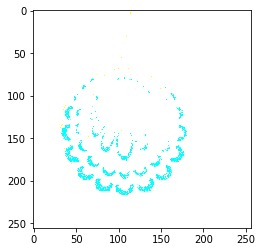

In [29]:
plt.imshow(iii.permute(1, 2, 0))

In [40]:
def render_animated_real(output_path, renderer, svbrdf):
    output_path.mkdir(parents=True, exist_ok=True)
    
    for i, phi in enumerate(np.linspace(0.0, np.pi*2, 120, endpoint=True)):
        cam       = env.Camera([0, -1, 1.4])
        light     = env.Light([1.7 * np.cos(phi), 1.7 * np.sin(phi), 1.7], [30, 30, 30])
        scene     = env.Scene(cam, light)
        rendering = renderer.render(scene, svbrdf).squeeze(0)
        
        mapping   = renderers.OrthoToPerspectiveMapping(cam, (512, 512))
        rendering = mapping.apply(utils.gamma_encode(rendering.clone().cpu().detach().permute(1, 2, 0)).numpy())

        output_file_path = output_path.joinpath("{:d}.png".format(i))
        utils.write_image(output_file_path, rendering)

In [43]:
# G:\svbrdf-estimation\presentations\final\results\0_artificial\gt
# G:\svbrdf-estimation\presentations\final\results\0_artificial\local
# G:\svbrdf-estimation\presentations\final\results\0_artificial\pt
# G:\svbrdf-estimation\presentations\final\results\0_artificial\reference

input_dir            = pathlib.Path(R"G:\svbrdf-estimation\presentations\final\results\0_real\reference")

data_svbrdf = dataset.SvbrdfDataset(data_directory=str(input_dir), 
                                    image_size=256, scale_mode='crop', input_image_count=0, used_input_image_count=0, 
                                    use_augmentation=False, mix_materials=False,
                                    no_svbrdf=False, is_linear=False)

renderer = renderers.LocalRenderer()

for i in range(len(data_svbrdf)):
    rendering_output_dir = input_dir.joinpath("{:d}".format(i))
    render_animated_real(rendering_output_dir, renderer, data_svbrdf[i]['svbrdf'])